# Setup

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


# YOLOv7

In [4]:
%cd {HOME}
!git clone https://github.com/WongKinYiu/yolov7
%cd {HOME}/yolov7
!pip install -r requirements.txt

/content
fatal: destination path 'yolov7' already exists and is not an empty directory.
/content/yolov7


In [5]:
import sys
sys.path.append(f"{HOME}/yolov7")

# Download Data

In [6]:
# %cd {HOME}
# !mkdir input
# %cd {HOME}/input

In [7]:
SOURCE_VIDEO_A_PATH = f"{HOME}/input/vid-left.mp4"
SOURCE_VIDEO_B_PATH = f"{HOME}/input/vid-mid.mp4"
SOURCE_VIDEO_C_PATH = f"{HOME}/input/vid-right.mp4"

# Utils

In [8]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(image[...,::-1])
    plt.show()

In [9]:
from typing import Optional, Tuple
from dataclasses import dataclass


@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

@dataclass
class Detection:
    rect: Rect
    class_id: int
    confidence: float
    tracker_id: Optional[int] = None


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

In [10]:
import cv2

import numpy as np

def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image

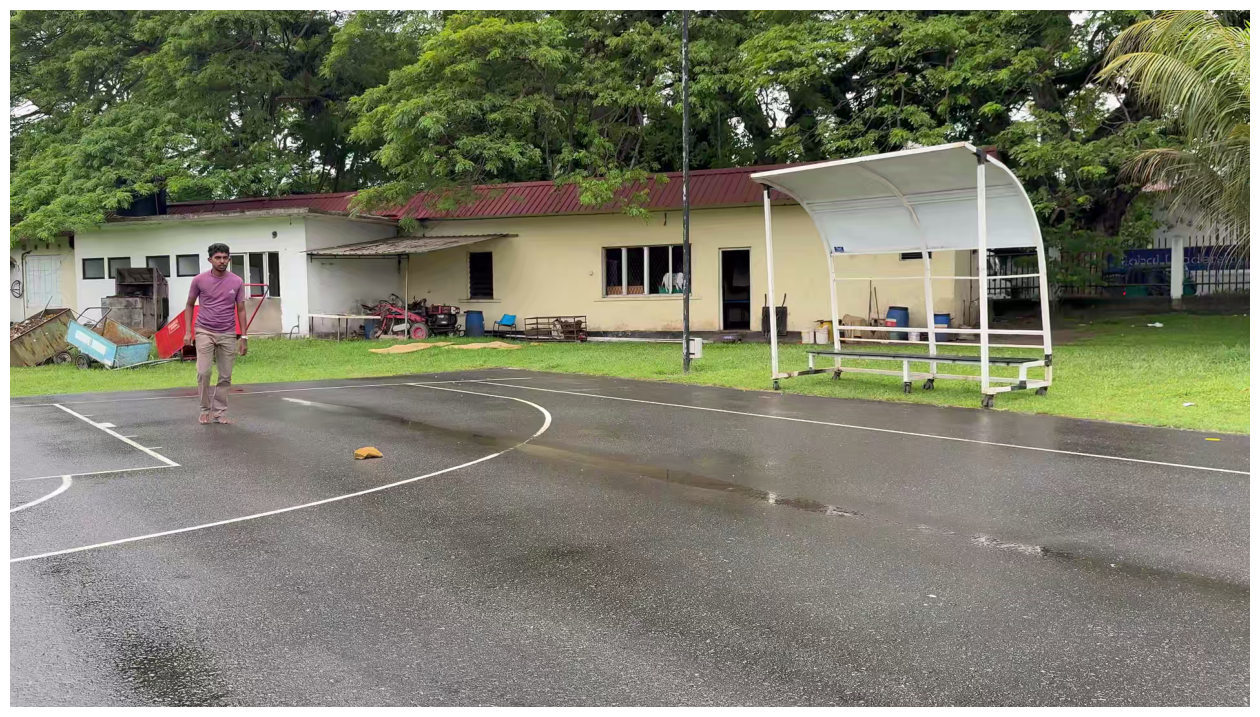

In [11]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))

frame = next(frame_iterator)
plot_image(frame, 16)

# Load YOLOv7 Models

Download Weights

In [12]:
%cd {HOME}/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt --quiet
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt --quiet

/content/yolov7


In [13]:
DETECTION_MODEL_WEIGHTS_PATH = f"{HOME}/yolov7/yolov7-e6e.pt"
POSE_MODEL_WEIGHTS_PATH = f"{HOME}/yolov7/yolov7-w6-pose.pt"

In [14]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Load Detection Model

In [15]:
from utils.general import check_img_size
from models.experimental import attempt_load
from models.common import ImplicitA, ImplicitM, ReOrg,Conv, Concat, DownC, Shortcut, SPPCSPC
from models.yolo import IKeypoint, Model, Detect
from torch import nn

torch.serialization.add_safe_globals([
    ImplicitA,
    ImplicitM,
    Model,
    ReOrg,
    Conv,
    DownC,
    Concat,
    Shortcut,
    SPPCSPC,
    Detect,
    IKeypoint,
    nn.modules.conv.Conv2d,
    nn.modules.batchnorm.BatchNorm2d,
    nn.modules.activation.SiLU,
    nn.modules.container.Sequential,
    nn.modules.pooling.MaxPool2d,
    nn.modules.container.ModuleList,
    nn.modules.upsampling.Upsample,
])

# torch.serialization.add_safe_globals([nn.Upsample])
detection_model = attempt_load(weights=DETECTION_MODEL_WEIGHTS_PATH, map_location=device)

Fusing layers... 


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Load Pose Model

In [16]:
weigths = attempt_load(POSE_MODEL_WEIGHTS_PATH, map_location=device)
pose_model = weigths
pose_model.eval()

if torch.cuda.is_available():
    pose_model.half().to(device)

Fusing layers... 


# Single Frame Inference

Settings

In [17]:
DETECTION_IMAGE_SIZE = 1920
POSE_IMAGE_SIZE = 960
STRIDE = 64
CONFIDENCE_TRESHOLD = 0.25
IOU_TRESHOLD = 0.65

Pre-process

In [18]:
from utils.datasets import letterbox
from torchvision import transforms

import numpy as np


def detection_pre_process_frame(frame: np.ndarray, device: torch.device) -> torch.Tensor:
    img = letterbox(frame, DETECTION_IMAGE_SIZE, STRIDE, auto=True)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    img = torch.from_numpy(img).to(device).float()
    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    return img

def pose_pre_process_frame(frame: np.ndarray, device: torch.device) -> torch.Tensor:
    image = letterbox(frame, POSE_IMAGE_SIZE, stride=STRIDE, auto=True)[0]
    image = transforms.ToTensor()(image)
    image = torch.tensor(np.array([image.numpy()]))

    if torch.cuda.is_available():
        image = image.half().to(device)

    return image

Post-process

In [19]:
from typing import Tuple

from utils.general import non_max_suppression_kpt, non_max_suppression
from utils.plots import output_to_keypoint

import numpy as np


def clip_coords(boxes: np.ndarray, img_shape: Tuple[int, int]):
    # Clip bounding xyxy bounding boxes to image shape (height, width)
    boxes[:, 0] = np.clip(boxes[:, 0], 0, img_shape[1]) # x1
    boxes[:, 1] = np.clip(boxes[:, 1], 0, img_shape[0]) # y1
    boxes[:, 2] = np.clip(boxes[:, 2], 0, img_shape[1]) # x2
    boxes[:, 3] = np.clip(boxes[:, 3], 0, img_shape[0]) # y2


def detection_post_process_output(
    output: torch.tensor,
    confidence_trashold: float,
    iou_trashold: float,
    image_size: Tuple[int, int],
    scaled_image_size: Tuple[int, int]
) -> np.ndarray:
    output = non_max_suppression(
        prediction=output,
        conf_thres=confidence_trashold,
        iou_thres=iou_trashold
    )
    coords = output[0].detach().cpu().numpy()

    v_gain = scaled_image_size[0] / image_size[0]
    h_gain = scaled_image_size[1] / image_size[1]

    coords[:, 0] /= h_gain
    coords[:, 1] /= v_gain
    coords[:, 2] /= h_gain
    coords[:, 3] /= v_gain

    clip_coords(coords, image_size)
    return coords


def post_process_pose(pose: np.ndarray, image_size: Tuple, scaled_image_size: Tuple) -> np.ndarray:
    height, width = image_size
    scaled_height, scaled_width = scaled_image_size
    vertical_factor = height / scaled_height
    horizontal_factor = width / scaled_width
    result = pose.copy()
    for i in range(17):
        result[i * 3] = horizontal_factor * result[i * 3]
        result[i * 3 + 1] = vertical_factor * result[i * 3 + 1]
    return result


def pose_post_process_output(
    output: torch.tensor,
    confidence_trashold: float,
    iou_trashold: float,
    image_size: Tuple[int, int],
    scaled_image_size: Tuple[int, int]
) -> np.ndarray:
    output = non_max_suppression_kpt(
        prediction=output,
        conf_thres=confidence_trashold,
        iou_thres=iou_trashold,
        nc=pose_model.yaml['nc'],
        nkpt=pose_model.yaml['nkpt'],
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)

        for idx in range(output.shape[0]):
            output[idx, 7:] = post_process_pose(
                output[idx, 7:],
                image_size=image_size,
                scaled_image_size=scaled_image_size
            )

    return output

Annotate

In [20]:
from utils.plots import plot_skeleton_kpts


def detect_annotate(image: np.ndarray, detections: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    annotated_image = image.copy()
    for x_min, y_min, x_max, y_max, confidence, class_id in detections:
        rect = Rect(
            x=float(x_min),
            y=float(y_min),
            width=float(x_max - x_min),
            height=float(y_max - y_min)
        )
        annotated_image = draw_rect(image=annotated_image, rect=rect, color=color, thickness=thickness)

    return annotated_image


def pose_annotate(image: np.ndarray, detections: np.ndarray) -> np.ndarray:
    annotated_frame = image.copy()

    # for idx in range(detections.shape[0]):
    #     pose = detections[idx, 7:].T
    #     plot_skeleton_kpts(annotated_frame, pose, 3)

    # Iterate over each detected person in the detections
    for idx in range(detections.shape[0]):
        # Extract keypoints for the pose
        pose = detections[idx, 7:]  # Extract keypoints
        if pose.ndim > 1:           # Flatten to 1D if needed
            pose = pose.flatten()

        plot_skeleton_kpts(annotated_frame, pose, 3)  # Plot skeleton keypoints

        # Draw each keypoint's index near the keypoint on the frame
        for i in range(len(pose) // 3):  # Iterate over each keypoint
            x = int(pose[i * 3])         # x-coordinate of the keypoint
            y = int(pose[i * 3 + 1])     # y-coordinate of the keypoint
            conf = pose[i * 3 + 2]       # confidence score

            if conf > 0.5:  # Only display if the confidence is above a threshold
                cv2.putText(
                    annotated_frame,
                    str(i),                # Text to display (index of keypoint)
                    (x, y),                # Position to display the text
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,                   # Font scale
                    (255, 255, 255),           # Color (White)
                    1,                     # Thickness
                    cv2.LINE_AA
                )

    return annotated_frame

Single Frame Detection

In [21]:
COLOR = Color(r=255, g=255, b=255)

frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))

frame = next(frame_iterator)

detection_pre_processed_frame = detection_pre_process_frame(
    frame=frame,
    device=device
)

image_size = frame.shape[:2]
scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

with torch.no_grad():

    detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()

    detection_output = detection_post_process_output(
        output=detection_output,
        confidence_trashold=CONFIDENCE_TRESHOLD,
        iou_trashold=IOU_TRESHOLD,
        image_size=image_size,
        scaled_image_size=scaled_image_size
    )

annotated_frame = detect_annotate(image=frame, detections=detection_output, color=COLOR)

plot_image(annotated_frame, 16)

Single Frame Pose

In [22]:
def process_frame_and_annotate(frame: np.ndarray) -> np.ndarray:
    pose_pre_processed_frame = pose_pre_process_frame(frame=frame.copy(), device=device)

    image_size = frame.shape[:2]
    scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

    with torch.no_grad():
        pose_output, _ = pose_model(pose_pre_processed_frame)
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=scaled_image_size
        )

    annotated_frame = pose_annotate(image=frame, detections=pose_output)

    return annotated_frame

In [23]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))

frame = next(frame_iterator)

annotated_frame = process_frame_and_annotate(frame=frame)

plot_image(annotated_frame, 16)

In [24]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_B_PATH))

frame = next(frame_iterator)

annotated_frame = process_frame_and_annotate(frame=frame)

plot_image(annotated_frame, 16)

# Process Video

In [25]:
from dataclasses import dataclass

import cv2


"""
usage example:

video_config = VideoConfig(
    fps=30,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)

video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int


# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=video_config.fps,
        frameSize=(video_config.width, video_config.height),
        isColor=True
    )


def get_frame_count(path: str) -> int:
    cap = cv2.VideoCapture(SOURCE_VIDEO_B_PATH)
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [26]:
SOURCE_VIDEO_PATH = SOURCE_VIDEO_B_PATH
TARGET_VIDEO_PATH = f"{HOME}/output/pose-estimation-synchronised-sample-b.mp4"

In [ ]:
from tqdm.notebook import tqdm
import time

COLOR = Color(r=255, g=255, b=255)

# initiate video writer
video_config = VideoConfig(
    fps=25,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

total = get_frame_count(SOURCE_VIDEO_PATH)

for i,frame in enumerate(tqdm(frame_iterator, total=total)):
    start_time = time.time()
    # print(f"Processing fame {i+1}/{total}...")

    annotated_frame = frame.copy()

    with torch.no_grad():
        image_size = frame.shape[:2]

        #detection
        detection_pre_processed_frame = detection_pre_process_frame(
            frame=frame,
            device=device)
        detection_scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

        detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()
        detection_output = detection_post_process_output(
            output=detection_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=detection_scaled_image_size
        )
        annotated_frame = detect_annotate(
            image=annotated_frame, detections=detection_output, color=COLOR)

        # pose
        pose_pre_processed_frame = pose_pre_process_frame(
            frame=frame,
            device=device)
        pose_scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

        pose_output = pose_model(pose_pre_processed_frame)[0].detach().cpu()
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=pose_scaled_image_size
        )
        annotated_frame = pose_annotate(
            image=annotated_frame, detections=pose_output)


        # Log annotated frame dimensions
        # print(f"Annotated frame dimensions before resize: {annotated_frame.shape}")

        # Resize the annotated frame if dimensions do not match (again)
        if annotated_frame.shape[:2] != (1080, 1920):
            # print(f"Resizing annotated frame from {annotated_frame.shape[:2]} to (1080, 1920)...")
            annotated_frame = cv2.resize(annotated_frame, (1920, 1080))

        # Check if the annotated frame's dimensions are valid after resize
        # print(f"Annotated frame dimensions after resize: {annotated_frame.shape}")

        # Check if frame is valid (not None) and has the right dimensions
        if annotated_frame is not None and annotated_frame.shape[:2] == (1080, 1920):
            video_writer.write(annotated_frame)
        else:
            print(f"Frame {i+1} is invalid or has the wrong dimensions!")

        # save video frame
        # video_writer.write(annotated_frame)

    # Print how long the processing for this frame took
    # print(f"Frame {i+1} processed in {time.time() - start_time:.4f} seconds")

# close output video
video_writer.release()

  0%|          | 0/104 [00:00<?, ?it/s]

# Process and Save Results to Join

In [ ]:
from typing import Union

import json
import os

def create_parent_dir(file_path: str) -> None:
    file_directory = os.path.dirname(os.path.abspath(file_path))
    os.makedirs(file_directory, exist_ok=True)


def dump_json_file(file_path: str, content: Union[list, dict], **kwargs) -> None:
    create_parent_dir(file_path=file_path)
    with open(file_path, "w") as file:
        json.dump(content, file, **kwargs)

def dump_excel_file(file_path: str, content: list) -> None:
    create_parent_dir(file_path=file_path)

    # Convert list of dictionaries into a pandas DataFrame
    df = pd.DataFrame(content)

    # Dump data into an Excel file
    df.to_excel(file_path, index=False)

In [ ]:
import pandas as pd
import numpy as np
import math


# Define colors
KEYPOINT_COLOR = (255, 0, 0)  # Blue for keypoints
CONNECTION_COLOR = (0, 255, 0)  # Green for connections
ANGLE_COLOR_SMALL = (0, 0, 255)  # Red for small angles
ANGLE_COLOR_LARGE = (0, 255, 0)  # Green for larger angles


CONNECTIONS = [(8, 6), (6, 12)]


def calculate_angle(kpts,p1,p2,p3):
    coord = []
    no_kpt = len(kpts)//3
    for i in range(no_kpt):
      cx,cy = kpts[3*i], kpts[3*i +1]
      conf = kpts[3*i +2]
      coord.append([i,cx,cy,conf])

    points = (p1,p2,p3)


    x1,y1 = coord[p1][1:3]
    x2,y2 = coord[p2][1:3]
    x3,y3 = coord[p3][1:3]

    angle = math.degrees(math.atan2(y3-y2,x3-x2)-math.atan2(y1-y2,x1-x2))

    if angle < 0:
      angle += 360

    if angle > 180:
      angle = 360 - angle

    return int(angle)


def draw_angle_on_frame(frame, frame_number, angle, position):
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # cv2.putText(frame, f"Right Knee Angle: {angle} degrees", position, font, 0.6, (0, 255, 0), 2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2
    text_color = (0, 255, 0)  # Green text
    border_color = (0, 0, 255)  # Blue border
    border_thickness = 2
    padding = 5  # Padding around the text inside the border

    # Create the text string
    # text = f"Right Shoulder Angle: {angle} degrees"
    text = f"Frame No: {frame_number}"

    # Get the size of the text
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_width, text_height = text_size[0]
    baseline = text_size[1]

    # Define the top-left and bottom-right corners of the border
    top_left = (position[0] - padding, position[1] - text_height - baseline - padding)
    bottom_right = (position[0] + text_width + padding, position[1] + baseline)

    # Draw the rectangle border
    cv2.rectangle(frame, top_left, bottom_right, border_color, border_thickness)

    # Position of the text inside the border
    text_position = (position[0], position[1] - baseline)

    # Draw the text
    cv2.putText(frame, text, text_position, font, font_scale, text_color, font_thickness)


def process_and_dump(source_video_path: str, target_json_path: str, target_excel_path:str, target_video_path: str, angle_plot_path: str, task_output_path: str, video_angle: str, point_indices: list[int]) -> None:
    frame_iterator = iter(generate_frames(video_file=source_video_path))
    total = get_frame_count(source_video_path)
    entries = []
    angle_changes = []
    shoulder_angle = []
    bowling_elbow_angle = []
    front_knee_angle = []

    # Keypoint indices for specific landmarks
    SIDE_POINT1_INDEX = point_indices[0]
    MID_POINT_INDEX = point_indices[1]
    SIDE_POINT2_INDEX = point_indices[2]

    # Open video for writing
    cap = cv2.VideoCapture(source_video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    out = cv2.VideoWriter(target_video_path, fourcc, fps, (frame_width, frame_height))

    frame_number = 0

    for frame in tqdm(frame_iterator, total=total):
        image_size = frame.shape[:2]

        #detection
        detection_pre_processed_frame = detection_pre_process_frame(frame=frame, device=device)
        detection_scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

        detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()
        detection_output = detection_post_process_output(
            output=detection_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=detection_scaled_image_size
        )

        # pose
        pose_pre_processed_frame = pose_pre_process_frame(frame=frame, device=device)
        pose_scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

        pose_output = pose_model(pose_pre_processed_frame)[0].detach().cpu()
        pose_output1 = pose_model(pose_pre_processed_frame)[0].detach().cpu()
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=pose_scaled_image_size
        )

        pose_output1 = non_max_suppression_kpt(
            pose_output1,
            0.25,
            0.65,
            nc=pose_model.yaml['nc'],
            nkpt=pose_model.yaml['nkpt'],
            kpt_label=True
        )
        pose_output1 = output_to_keypoint(pose_output1)

        for idx in range(pose_output1.shape[0]):
          kpts=pose_output1[idx,7:].T
          elbow_angle = calculate_angle(kpts, SIDE_POINT1_INDEX, MID_POINT_INDEX, SIDE_POINT2_INDEX)

          # Draw the angle on the frame
          draw_angle_on_frame(frame, frame_number, elbow_angle, (50, 50))

          # Save angle and corresponding time for plotting
          angle_changes.append((frame_number / fps, elbow_angle))
          shoulder_angle.append((frame_number, elbow_angle))
          bowling_elbow_angle.append((frame_number, elbow_angle))

        # Save frame to video
        out.write(frame)

        entry = {
            "detection": detection_output.tolist(),
            "pose": pose_output.tolist()
        }
        entries.append(entry)

        frame_number += 1

    # Release the video writer and video capture
    out.release()
    cap.release()

    # Save to JSON
    dump_json_file(file_path=target_json_path, content=entries)

    # Save to Excel
    # dump_excel_file(file_path=target_excel_path, content=entries)

    joint_angle = pd.DataFrame(bowling_elbow_angle, columns=["Frame","Bowling Elbow Flexion-Extension Angle (degrees)"])
    joint_angle.to_excel(target_excel_path, index=False)
    # joint_angle.to_excel(f"{task_output_path}/bowling_elbow_angle_{video_angle}.xlsx", index=False)

In [ ]:
process_and_dump(SOURCE_VIDEO_A_PATH, f"{HOME}/output/pose-estimation-synchronised-sample-a.json", f"{HOME}/output/bowling_elbow_angle_left.xlsx", f"{HOME}/output/bowling_elbow_angle_left.mp4", f"{HOME}/output/bowling_elbow_angle_left.png", f"{HOME}/output", "left", [6, 8, 10])
process_and_dump(SOURCE_VIDEO_B_PATH, f"{HOME}/output/pose-estimation-synchronised-sample-b.json", f"{HOME}/output/bowling_elbow_angle_mid.xlsx", f"{HOME}/output/bowling_elbow_angle_mid.mp4", f"{HOME}/output/bowling_elbow_angle_mid.png", f"{HOME}/output", "mid", [6, 8, 10])
process_and_dump(SOURCE_VIDEO_C_PATH, f"{HOME}/output/pose-estimation-synchronised-sample-c.json", f"{HOME}/output/bowling_elbow_angle_right.xlsx", f"{HOME}/output/bowling_elbow_angle_right.mp4", f"{HOME}/output/bowling_elbow_angle_right.png", f"{HOME}/output", "right", [6, 8, 10])

In [ ]:
import os
os.chdir('..')
%cd content
HOME = os.getcwd()
print(HOME)

# **Animation Creation**

# Setup

In [ ]:
import os
os.chdir('..')
%cd content
# print(os.getcwd())

In [ ]:
FRAME_WIDTH = 1920
FRAME_HEIGHT = 1080

In [ ]:

VIEW_X_MIN = - 500
VIEW_X_MAX = 500
VIEW_Y_MIN = - 500
VIEW_Y_MAX = 500
VIEW_Z_MIN = 0
VIEW_Z_MAX = 1000

POSE_ANCHORS = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [5,6],
    [5,7],
    [6,8],
    [7,9],
    [8,10],
    [5,11],
    [6,12],
    [11,12],
    [11,13],
    [12,14],
    [13,15],
    [14,16]
]

In [ ]:
from dataclasses import dataclass
from typing import List

import numpy as np

import json


@dataclass
class FrameData:
    pose: np.ndarray
    detection: np.ndarray


def load_json(path: str) -> dict:
    with open(path) as f:
        contents = f.read()
        return json.loads(contents)


def load_extracted_data(path: str) -> List[FrameData]:
    raw = load_json(path)
    return [
        FrameData(
            pose=entry['pose'],
            detection=entry['detection']
        )
        for entry
        in raw
    ]

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

In [ ]:
EXTRACTED_DATA_A_PATH = f"{HOME}/output/pose-estimation-synchronised-sample-a.json"
EXTRACTED_DATA_B_PATH = f"{HOME}/output/pose-estimation-synchronised-sample-b.json"
EXTRACTED_DATA_C_PATH = f"{HOME}/output/pose-estimation-synchronised-sample-c.json"

In [ ]:
extracted_data_a = load_extracted_data(EXTRACTED_DATA_A_PATH)
extracted_data_b = load_extracted_data(EXTRACTED_DATA_B_PATH)
extracted_data_c = load_extracted_data(EXTRACTED_DATA_C_PATH)

In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional, List, Tuple


@dataclass
class Pose:
    x: np.ndarray
    y: np.ndarray
    confidence: np.ndarray

    @classmethod
    def load(cls, data: List[float]) -> Pose:
        x, y, confidence = [], [], []
        for i in range(17):
            x.append(data[7 + i * 3])
            y.append(data[7 + i * 3 + 1])
            confidence.append(data[7 + i * 3 + 2])
        return Pose(
            x=np.array(x),
            y=np.array(y),
            confidence=np.array(confidence)
        )


@dataclass
class Pose3D:
    x: np.ndarray
    y: np.ndarray
    z: np.ndarray

    @classmethod
    def from2D(cls, pose_a: Pose, pose_b: Pose, pose_c: Pose) -> Pose3D:
        return Pose3D(
            x=pose_a.x,
            y=pose_b.x,
            z=(pose_a.y + pose_b.y + pose_c.y) / 3
        )


from dataclasses import dataclass
from typing import List, Optional

# Point class represents a point with x and y coordinates
@dataclass
class Point:
    x: float
    y: float

# Detection class represents a bounding box around a detected object
@dataclass
class Detection:
    x_min: float
    y_min: float
    x_max: float
    y_max: float
    confidence: float
    class_id: int

    @property
    def width(self) -> float:
        return self.x_max - self.x_min

    @property
    def height(self) -> float:
        return self.y_max - self.y_min

    @property
    def center(self) -> Point:
        return Point(
            x=(self.x_min + self.x_max) / 2,
            y=(self.y_min + self.y_max) / 2
        )

    @classmethod
    def load(cls, data: List[float]) -> 'Detection':
        return Detection(
            x_min=float(data[0]),
            y_min=float(data[1]),
            x_max=float(data[2]),
            y_max=float(data[3]),
            confidence=float(data[4]),
            class_id=int(data[5])
        )

    @classmethod
    def filter(cls, detections: List['Detection'], person_class_id: int = 0) -> Optional['Detection']:
        # Filter detections for the person class (default class ID is 0)
        filtered_detections = [
            detection for detection in detections
            if detection.class_id == person_class_id
        ]
        # Return the first detection of a person if one exists
        return filtered_detections[0] if filtered_detections else None


In [ ]:
detections = [Detection.load(detection) for detection in extracted_data_a[0].detection]
detection_person = Detection.filter(detections)

# Check if a person was detected
if detection_person is not None:
    pose_a = Pose.load(extracted_data_a[0].pose[0])  # Load the person's pose data
else:
    pose_a = None  # Handle the case where no person is detected


In [ ]:
import matplotlib.pyplot as plt

# Check if pose_a is valid (i.e., person detected)
if pose_a is not None:
    fig = plt.figure(figsize=(20, 12))
    plt.scatter(pose_a.x, pose_a.y, color="red")
    plt.xlim([0, FRAME_WIDTH])
    plt.ylim([0, FRAME_HEIGHT])
    plt.gca().invert_yaxis()  # Invert y-axis if needed to match the video coordinates
    plt.show()
else:
    # Show a completely blank page
    fig = plt.figure(figsize=(20, 12))
    plt.xlim([0, FRAME_WIDTH])
    plt.ylim([0, FRAME_HEIGHT])
    plt.gca().invert_yaxis()  # Match the y-axis orientation with the video
    plt.show()  # Show blank plot without text or scatter points

In [ ]:
if detection_person is not None:
    pose_b = Pose.load(extracted_data_b[0].pose[0])  # Load the person's pose data
else:
    pose_b = None

In [ ]:
import matplotlib.pyplot as plt

# Check if pose_a is valid (i.e., person detected)
if pose_b is not None:
    fig = plt.figure(figsize=(20, 12))
    plt.scatter(pose_b.x, pose_b.y, color="red")
    plt.xlim([0, FRAME_WIDTH])
    plt.ylim([0, FRAME_HEIGHT])
    plt.gca().invert_yaxis()  # Invert y-axis if needed to match the video coordinates
    plt.show()
else:
    # Show a completely blank page
    fig = plt.figure(figsize=(20, 12))
    plt.xlim([0, FRAME_WIDTH])
    plt.ylim([0, FRAME_HEIGHT])
    plt.gca().invert_yaxis()  # Match the y-axis orientation with the video
    plt.show()  # Show blank plot without text or scatter points

In [ ]:
if detection_person is not None:
    pose_c = Pose.load(extracted_data_c[0].pose[0])  # Load the person's pose data
else:
    pose_c = None

In [ ]:
import matplotlib.pyplot as plt

# Check if pose_a is valid (i.e., person detected)
if pose_c is not None:
    fig = plt.figure(figsize=(20, 12))
    plt.scatter(pose_c.x, pose_c.y, color="red")
    plt.xlim([0, FRAME_WIDTH])
    plt.ylim([0, FRAME_HEIGHT])
    plt.gca().invert_yaxis()  # Invert y-axis if needed to match the video coordinates
    plt.show()
else:
    # Show a completely blank page
    fig = plt.figure(figsize=(20, 12))
    plt.xlim([0, FRAME_WIDTH])
    plt.ylim([0, FRAME_HEIGHT])
    plt.gca().invert_yaxis()  # Match the y-axis orientation with the video
    plt.show()  # Show blank plot without text or scatter points

In [ ]:
detections = [Detection.load(detection) for detection in extracted_data_a[0].detection]
detection_a = Detection.filter(detections, 0)
pose_a = Pose.load(extracted_data_a[0].pose[0])
BASELINE_HEIGHT_A = detection_a.height
BASELINE_VERTICAL_OFFSET_A = detection_a.y_max - pose_a.y.max()
print("BASELINE_HEIGHT_A", BASELINE_HEIGHT_A)
print("BASELINE_VERTICAL_OFFSET_A", BASELINE_VERTICAL_OFFSET_A)

detections = [Detection.load(detection) for detection in extracted_data_b[0].detection]
detection_b = Detection.filter(detections, 0)
pose_b = Pose.load(extracted_data_b[0].pose[0])
BASELINE_VERTICAL_OFFSET_B = detection_b.y_max - pose_b.y.max()
BASELINE_HEIGHT_B = detection_b.height
print("BASELINE_HEIGHT_B", BASELINE_HEIGHT_B)
print("BASELINE_VERTICAL_OFFSET_B", BASELINE_VERTICAL_OFFSET_B)

detections = [Detection.load(detection) for detection in extracted_data_c[0].detection]
detection_c = Detection.filter(detections, 0)
pose_c = Pose.load(extracted_data_c[0].pose[0])
BASELINE_VERTICAL_OFFSET_C = detection_c.y_max - pose_c.y.max()
BASELINE_HEIGHT_C = detection_c.height
print("BASELINE_HEIGHT_C", BASELINE_HEIGHT_C)
print("BASELINE_VERTICAL_OFFSET_C", BASELINE_VERTICAL_OFFSET_C)

In [ ]:
from typing import Optional, Tuple


def calibrate(
    data: FrameData,
    frame_height: int,
    baseline_pose_height: float,
    baseline_vertical_offset: float
) -> Optional[Tuple[Pose, Point]]:
    detections = [Detection.load(detection) for detection in data.detection]
    detection_person = Detection.filter(detections, 0)
    # detection_ball = Detection.filter(detections, 32)

    if detection_person is None:
        return None
    # if detection_ball is None:
    #     return None
    if len(data.pose) != 1:
        return None

    # ball_x, ball_y = detection_ball.center.int_xy_tuple

    pose = Pose.load(data.pose[0])
    pose.y = frame_height - pose.y
    # ball_y = frame_height - ball_y

    x_shift = (pose.x.max() + pose.x.min()) / 2
    y_shift = pose.y.min() - baseline_vertical_offset

    pose.x = pose.x - x_shift
    # ball_x = ball_x - x_shift
    pose.y = (pose.y - y_shift) * 1000 / baseline_pose_height
    # ball_y = (ball_y - y_shift) * 1000 / baseline_pose_height
    return pose

In [ ]:
pose_a = calibrate(extracted_data_a[0], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_a.x, pose_a.y, color="red")
# plt.scatter([point_a.x], [point_a.y], color="blue")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
pose_b = calibrate(extracted_data_b[0], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_b.x, pose_b.y, color="red")
# plt.scatter([point_b.x], [point_b.y], color="blue")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
pose_c = calibrate(extracted_data_c[0], FRAME_HEIGHT, BASELINE_HEIGHT_C, BASELINE_VERTICAL_OFFSET_C)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_c.x, pose_c.y, color="red")
# plt.scatter([point_b.x], [point_b.y], color="blue")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
pose_a = calibrate(extracted_data_a[0], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)
pose_b = calibrate(extracted_data_b[0], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)
pose_c = calibrate(extracted_data_c[0], FRAME_HEIGHT, BASELINE_HEIGHT_C, BASELINE_VERTICAL_OFFSET_C)

pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b, pose_c=pose_c)

In [ ]:
from typing import Tuple, List

from collections import deque


class Trace:

    def __init__(self, history: int = 10):
        self.x = deque(maxlen=history)
        self.y = deque(maxlen=history)
        self.z = deque(maxlen=history)

    def append(self, x: float, y: float, z: float):
        self.x.append(x)
        self.y.append(y)
        self.z.append(z)

    def get_state(self) -> Tuple[List[float], List[float], List[float]]:
        return list(self.x), list(self.y), list(self.z)

In [ ]:
from typing import Optional
import matplotlib.pyplot as plt
import random
import numpy as np


def calculate_angle_3d(a, b, c):

    # Calculate the angle between three points in 3D space.

    # Parameters:
    # a, b, c: 3D points as numpy arrays where b is the vertex (shoulder),
    #          a is one end (elbow), and c is the other end (hip).

    # Returns:
    # angle: The angle in degrees.

    a = np.array(a)  # First point (e.g., elbow)
    b = np.array(b)  # Middle point (e.g., shoulder)
    c = np.array(c)  # End point (e.g., hip)

    # Vector BA and BC
    ba = a - b
    bc = c - b

    # Calculate the cosine of the angle using the dot product formula
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

    # Clip the cosine value to the range [-1, 1] to avoid numerical errors
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

    # Calculate the angle in radians and then convert to degrees
    angle = np.arccos(cosine_angle) * (180.0 / np.pi)

    return angle


def draw_3d1(
    pose3d: Pose3D,
    bowling_elbow_angle: float = 0.0,
    angle: int = 0,
    frame_number: int = 0,
    save_path: Optional[str] = None,
    foot_1_trace: Optional[Trace] = None,
    foot_2_trace: Optional[Trace] = None,
    angle_point: Optional[str] = "",
) -> None:

    plt.style.use('dark_background')

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.axes.set_xlim3d(left=VIEW_X_MIN, right=VIEW_X_MAX)
    ax.axes.set_ylim3d(bottom=VIEW_Y_MIN, top=VIEW_Y_MAX)
    ax.axes.set_zlim3d(bottom=VIEW_Z_MIN, top=VIEW_Z_MAX)

    # Plot the pose anchors
    for pose_anchor in POSE_ANCHORS:
        ax.plot(pose3d.x[pose_anchor], pose3d.y[pose_anchor], pose3d.z[pose_anchor], color="#ffffff", linewidth=5)

    # Add the calculated angle as text to the plot
    fig.text(0.05, 0.95, f"Bowling Elbow Flexion-Extension Angle: {bowling_elbow_angle:.2f}°", color="yellow", fontsize=24,
             verticalalignment='top', horizontalalignment='left', backgroundcolor="black")

    fig.text(0.05, 0.85, f"Front Knee Flexion-Extension Angle: {front_knee_angle:.2f}°", color="yellow", fontsize=24,
             verticalalignment='top', horizontalalignment='left', backgroundcolor="black")

    # Plot foot trace 1 if available
    if foot_1_trace is not None:
        foot_1_trace_x, foot_1_trace_y, foot_1_trace_z = foot_1_trace.get_state()
        ax.plot(foot_1_trace_x, foot_1_trace_y, foot_1_trace_z, color="#fecea8", linewidth=2)

    # Plot foot trace 2 if available
    if foot_2_trace is not None:
        foot_2_trace_x, foot_2_trace_y, foot_2_trace_z = foot_2_trace.get_state()
        ax.plot(foot_2_trace_x, foot_2_trace_y, foot_2_trace_z, color="#fecea8", linewidth=2)

    # Scatter plot for the pose
    ax.scatter(pose3d.x, pose3d.y, pose3d.z, color="#ffffff")

    # Set the viewing angle
    ax.view_init(30, 45 + angle*2)

    # Save or show the plot
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close(fig)


In [ ]:
draw_3d1(pose3d)

In [ ]:
pose_a = calibrate(extracted_data_a[0], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)
pose_b = calibrate(extracted_data_b[0], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)
pose_c = calibrate(extracted_data_c[0], FRAME_HEIGHT, BASELINE_HEIGHT_C, BASELINE_VERTICAL_OFFSET_C)

pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b, pose_c=pose_c)

draw_3d1(pose3d, 60)

In [ ]:
OUTPUT_DIR = "frames"

In [ ]:
import os
os.chdir('..')
%cd {HOME}
!mkdir -p $OUTPUT_DIR

In [ ]:
import json

def save_to_json(frame_index: int, pose3d: Pose3D, json_data: dict):
    json_data[frame_index] = {
        "pose": {
            "x": pose3d.x.tolist(),
            "y": pose3d.y.tolist(),
            "z": pose3d.z.tolist()
        }
    }


def save_to_excel(json_data: dict, excel_file_path: str, angle_data: dict):
    # Create a list to hold the structured data
    data = []

    # Loop through the json_data to extract the frame and 3D pose information
    for frame_index, frame_data in json_data.items():
        # Get the x, y, z lists for the current frame
        x_coords = frame_data['pose']['x']
        y_coords = frame_data['pose']['y']
        z_coords = frame_data['pose']['z']
        angle = angle_data.get(frame_index, None)

        # Combine all keypoints for this frame into rows (one row per frame)
        for kp_idx in range(len(x_coords)):
            data.append([frame_index, kp_idx + 1, x_coords[kp_idx], y_coords[kp_idx], z_coords[kp_idx], angle])

    # Create a DataFrame with appropriate column names
    df = pd.DataFrame(data, columns=['Frame', 'Keypoint', 'X', 'Y', 'Z', 'Elbow_Angle'])

    # Save the DataFrame to an Excel file
    df.to_excel(excel_file_path, index=False)
    print(f"Excel file saved to {excel_file_path}")

In [ ]:
pip install pandas openpyxl

In [ ]:
from tqdm import trange
import pandas as pd
import numpy as np

head_idx = 0  # Index for head keypoint
foot_idx = 15  # Index for foot keypoint (adjust based on your dataset)

def calculate_distance(point1, point2):
    """Calculate Euclidean distance between two 3D points."""
    return np.sqrt((point2[0] - point1[0]) ** 2 +
                   (point2[1] - point1[1]) ** 2 +
                   (point2[2] - point1[2]) ** 2)

def calculate_pose_anchor_distances(pose3d, anchors):
    """Calculate distances between keypoint pairs defined in POSE_ANCHORS."""
    distances = []
    for anchor in anchors:
        kp1_idx, kp2_idx = anchor
        point1 = (pose3d.x[kp1_idx], pose3d.y[kp1_idx], pose3d.z[kp1_idx])
        point2 = (pose3d.x[kp2_idx], pose3d.y[kp2_idx], pose3d.z[kp2_idx])
        distance = calculate_distance(point1, point2)
        distances.append(distance)
    return distances

def calculate_person_height_in_pixels(pose3d):
    """Calculate the height of a person in pixels using 3D pose keypoints."""
    head_point = (pose3d.x[head_idx], pose3d.y[head_idx], pose3d.z[head_idx])
    foot_point = (pose3d.x[foot_idx], pose3d.y[foot_idx], pose3d.z[foot_idx])

    # Calculate the distance between the head and foot in 3D space (in pixels)
    pixel_height = calculate_distance(head_point, foot_point)
    return pixel_height

# Step 2: Convert pixel height to real height (meters)
def calculate_real_height(pixel_height, pixel_to_meter_ratio):
    """Convert pixel height to real-world height (in meters)."""
    real_height = pixel_height * pixel_to_meter_ratio
    return real_height


def calculate_angle(a, b, c):
    """Calculate angle ABC given three points A, B, C."""
    ab = np.array(b) - np.array(a)
    cb = np.array(b) - np.array(c)

    # Use the dot product to find the cosine of the angle
    cosine_angle = np.dot(ab, cb) / (np.linalg.norm(ab) * np.linalg.norm(cb))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # Clip for numerical stability
    return np.degrees(angle)  # Convert from radians to degrees


# Example usage
pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b, pose_c=pose_c)  # Example pose data
pixel_height = calculate_person_height_in_pixels(pose3d)

# Assuming a pixel-to-meter ratio, e.g., 0.002 meters per pixel
# pixel_to_meter_ratio = object_height_in_meters / object_height_in_pixels
pixel_to_meter_ratio = 0.002  # meters per pixel (this should be calculated or calibrated)

person_real_height = calculate_real_height(pixel_height, pixel_to_meter_ratio)
print(f"The person's estimated height is: {person_real_height} meters")

def generate_frames(start=0, end=100):
    foot_1_trace = Trace(10)
    foot_2_trace = Trace(10)
    json_data = {}
    angle_data = {}
    bowling_elbow_angle_data = {}
    front_knee_angle_data = {}

    # Initialize an empty DataFrame for storing distances
    distance_columns = ['Frame'] + [f'Distance_{i}' for i in range(len(POSE_ANCHORS))]
    distance_df = pd.DataFrame(columns=distance_columns)

    for i in trange(start, end):
        a = calibrate(extracted_data_a[i], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)
        b = calibrate(extracted_data_b[i], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)
        c = calibrate(extracted_data_c[i], FRAME_HEIGHT, BASELINE_HEIGHT_C, BASELINE_VERTICAL_OFFSET_C)

        if a is None or b is None or c is None:
            continue

        pose_a = a
        pose_b = b
        pose_c = c

        pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b, pose_c=pose_c)
        foot_1_trace.append(x=pose3d.x[-1], y=pose3d.y[-1], z=pose3d.z[-1])
        foot_2_trace.append(x=pose3d.x[-2], y=pose3d.y[-2], z=pose3d.z[-2])

        # Calculate distances for the pose keypoints
        distances = calculate_pose_anchor_distances(pose3d, POSE_ANCHORS)
        new_row = pd.DataFrame([[i] + distances], columns=distance_df.columns)
        distance_df = pd.concat([distance_df, new_row], ignore_index=True)

        save_to_json(i, pose3d, json_data)

        shoulder_idx = 6
        elbow_idx = 8
        wrist_idx = 10

        fps = 30
        frame_number = i

        # Calculate the elbow angles in 2D for each pose
        elbow_angle_a = calculate_angle(
            (pose_a.x[shoulder_idx], pose_a.y[shoulder_idx]),
            (pose_a.x[elbow_idx], pose_a.y[elbow_idx]),
            (pose_a.x[wrist_idx], pose_a.y[wrist_idx])
        )

        elbow_angle_b = calculate_angle(
            (pose_b.x[shoulder_idx], pose_b.y[shoulder_idx]),
            (pose_b.x[elbow_idx], pose_b.y[elbow_idx]),
            (pose_b.x[wrist_idx], pose_b.y[wrist_idx])
        )

        elbow_angle_c = calculate_angle(
            (pose_c.x[shoulder_idx], pose_c.y[shoulder_idx]),
            (pose_c.x[elbow_idx], pose_c.y[elbow_idx]),
            (pose_c.x[wrist_idx], pose_c.y[wrist_idx])
        )

        # Calculate the elbow angle in 3D for the reconstructed pose
        elbow_angle_3d = calculate_angle_3d(
            (pose3d.x[shoulder_idx], pose3d.y[shoulder_idx], pose3d.z[shoulder_idx]),
            (pose3d.x[elbow_idx], pose3d.y[elbow_idx], pose3d.z[elbow_idx]),
            (pose3d.x[wrist_idx], pose3d.y[wrist_idx], pose3d.z[wrist_idx])
        )

        # Store all the calculated elbow angles in the angle_data dictionary
        angle_data[i] = {
            'shoulder_angle_a': elbow_angle_a,
            'shoulder_angle_b': elbow_angle_b,
            'shoulder_angle_c': elbow_angle_c,
            'shoulder_angle_3d': elbow_angle_3d,
        }

        bowling_elbow_angle_data[i] = {
            'bowling_elbow_angle_3d': elbow_angle_3d,
        }

        file_name = f"file{str(i).zfill(4)}.png"
        draw_3d1(
            pose3d,
            angle=i // 2,
            frame_number=frame_number,
            bowling_elbow_angle = elbow_angle_3d,
            save_path=f"{HOME}/{OUTPUT_DIR}/{file_name}",
        )


    with open(f"{HOME}/{OUTPUT_DIR}/coordinates.json", 'w') as json_file:
        json.dump(json_data, json_file, indent=4)

    with open(f"{HOME}/{OUTPUT_DIR}/angles.json", 'w') as angle_file:
        json.dump(angle_data, angle_file, indent=4)

    excel_file_path = f"{HOME}/{OUTPUT_DIR}/coordinates.xlsx"
    save_to_excel(json_data, excel_file_path, angle_data)

    excel_file_path = f"{HOME}/pose_distances.xlsx"
    distance_df.to_excel(excel_file_path, index=False)
    print(f"Excel file saved to {excel_file_path}")

    bowling_elbow_angle_df = pd.DataFrame.from_dict(bowling_elbow_angle_data, orient='index')
    bowling_elbow_angle_df.index.name = 'Frame'
    bowling_elbow_angle_file_path = f"{HOME}/{OUTPUT_DIR}/bowling_elbow_angles.xlsx"
    bowling_elbow_angle_df.to_excel(bowling_elbow_angle_file_path, index=True)
    print(f"Bowling elbow flexion-extension angles saved to {bowling_elbow_angle_file_path}")

    front_knee_angle_df = pd.DataFrame.from_dict(front_knee_angle_data, orient='index')
    front_knee_angle_df.index.name = 'Frame'
    front_knee_angle_file_path = f"{HOME}/{OUTPUT_DIR}/front_knee_angles.xlsx"
    front_knee_angle_df.to_excel(front_knee_angle_file_path, index=True)
    print(f"Front knee flexion-extension angles saved to {front_knee_angle_file_path}")

In [ ]:
# generate_frames(0, len(extracted_data_a))
generate_frames(0, len(extracted_data_b))
# generate_frames(0, len(extracted_data_c))

In [ ]:
import cv2
import os

def create_video_from_images(image_folder, video_name, fps=30):
    images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]

    if not images:
        print("No PNG images found in the specified directory.")
        return

    frame = cv2.imread(os.path.join(image_folder, images[0]))

    if frame is None:
        print("Error reading the first image.")
        return

    height, width, _ = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        img_path = os.path.join(image_folder, image)
        img_frame = cv2.imread(img_path)
        if img_frame is None:
            print(f"Error reading image: {img_path}")
            continue
        video.write(img_frame)

    video.release()
    print(f"Video saved as: {video_name}")

# Call the function:
create_video_from_images(OUTPUT_DIR, "output_video.mp4", fps=30)

In [ ]:
import pandas as pd

print(HOME)
bowling_elbow_angle_left = pd.read_excel(f"{HOME}/output/bowling_elbow_angle_left.xlsx")
bowling_elbow_angle_mid = pd.read_excel(f"{HOME}/output/bowling_elbow_angle_mid.xlsx")
bowling_elbow_angle_right = pd.read_excel(f"{HOME}/output/bowling_elbow_angle_right.xlsx")
bowling_elbow_angle_3d = pd.read_excel(f"{HOME}/frames/bowling_elbow_angles.xlsx")

# Rename columns to avoid conflicts during merge
bowling_elbow_angle_left = bowling_elbow_angle_left.rename(columns={"Bowling Elbow Flexion-Extension Angle (degrees)": "Bowling Elbow Left Cam Angle"})
bowling_elbow_angle_mid = bowling_elbow_angle_mid.rename(columns={"Bowling Elbow Flexion-Extension Angle (degrees)": "Bowling Elbow Mid Cam Angle"})
bowling_elbow_angle_right = bowling_elbow_angle_right.rename(columns={"Bowling Elbow Flexion-Extension Angle (degrees)": "Bowling Elbow Right Cam Angle"})
bowling_elbow_angle_3d = bowling_elbow_angle_3d.rename(columns={"bowling_elbow_angle_3d": "3D Bowling Elbow Angle"})

# Merge the DataFrames
bowling_elbow_angles = pd.merge(bowling_elbow_angle_left, bowling_elbow_angle_mid, on="Frame", how="outer")
bowling_elbow_angles = pd.merge(bowling_elbow_angles, bowling_elbow_angle_right, on="Frame", how="outer")
bowling_elbow_angles = pd.merge(bowling_elbow_angles, bowling_elbow_angle_3d, on="Frame", how="outer")

# Save the merged DataFrame to an Excel file, ignoring the index (unnamed) column
bowling_elbow_angles.to_excel(f"{HOME}/output/merged_bowling_elbow_angles.xlsx", index=False)

print(f"Merged bowling elbow angles saved to {HOME}/output/merged_bowling_elbow_angles.xlsx")

In [ ]:
import openpyxl

# Save from frame in excel and generate graph
def filter_excel_by_frame(start_frame, end_frame, input_excel_file, output_excel_file_path):
    workbook = openpyxl.load_workbook(input_excel_file)
    sheet = workbook.active

    new_workbook = openpyxl.Workbook()
    new_sheet = new_workbook.active

    header = [cell.value for cell in sheet[1]]
    for col_num, title in enumerate(header, 1):
        new_sheet.cell(row=1, column=col_num, value=title)

    row_num = 2

    for row in sheet.iter_rows(min_row=2):
        key_cell_value = row[0].value
        if start_frame <= key_cell_value <= end_frame:
            for col_num, cell in enumerate(row, 1):
                new_sheet.cell(row=row_num, column=col_num, value=cell.value)
            row_num+=1

    new_workbook.save(output_excel_file_path)


# Plot the graph
def plot_angle_changes(excel_file, title, ylabel, xlabel, output_plot_path):
    try:
        df = pd.read_excel(excel_file)

        if df.empty:
            print(f"Error: Excel file '{excel_file}' is empty.")
            return

        frame_column = df.columns[0]  # Assume the first column is the frame column

        numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
        numeric_columns.remove(frame_column) #remove the frame column from the list of numeric columns.

        if not numeric_columns:
            print(f"Error: No numeric columns found in '{excel_file}' (excluding the frame column).")
            return

        plt.figure(figsize=(10, 6))

        for angle_column in numeric_columns:
            plt.plot(df[frame_column], df[angle_column], label=angle_column)

        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)

        # Save the plot
        plt.savefig(output_plot_path)
        print(f"Plot saved to: {output_plot_path}")

        plt.show() # Display the plot

    except FileNotFoundError:
        print(f"Error: Excel file '{excel_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Bowling Elbow flexion-extension angle from bowling arm horizontally behind the body to the instant of ball release
filter_excel_by_frame(63, 70, f"{HOME}/output/merged_bowling_elbow_angles.xlsx", f"{HOME}/output/bowling_elbow_flexion_extension_angle.xlsx")
print(f"Bowling Elbow flexion-extension angle from bowling arm horizontally behind the body to the instant of ball release saved to {HOME}/output/bowling_elbow_flexion_extension_angle.xlsx")
plot_angle_changes(f"{HOME}/output/bowling_elbow_flexion_extension_angle.xlsx", "Bowling Flexion-Extension Angle (degrees) Change Over Time (s)", "Angle (degrees)", "Time (s)", f"{HOME}/output/bowling_elbow_flexion_extension_angle_change.png")